In [102]:
import pandas as pd
%reload_ext google.cloud.bigquery
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

## Question 1: What are the 5 most popular trips that you would call "commuter trips"?

In [87]:
%%bigquery --use_rest_api top_5_trips
SELECT
start_station_name,
end_station_name,
COUNT(*) AS number_of_trips
FROM
`bike_trip_data.commuter_trip_stations`
WHERE
start_station_name <> end_station_name
GROUP BY
start_station_name,
end_station_name
ORDER BY
number_of_trips DESC
LIMIT
5

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [88]:
top_5_trips

,start_station_name,end_station_name,number_of_trips
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,4582
1,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),4202
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,3918
3,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),3773
4,Embarcadero at Sansome,Steuart at Market,3762


### The top 5 commuter trips are:
1. From Harry Bridges Plaza (Ferry Building) to 2nd at Townsend (4582 trips)
2. From San Francisco Caltrain (Townsend at 4th) to Harry Bridges Plaza (Ferry Building) (4202 trips)
3. From San Francisco Caltrain 2 (330 Townsend) to Townsend at 7th (3918 trips)
4. From Townsend at 7th to San Francisco Caltrain 2 (330 Townsend) (3773 trips)
5. From Embarcadero at Sansome to Steuart at Market (3762 trips)

## Question 2: What are your recommendations for offers (justify based on your findings)?

### Recommendation 1: Offer a discount to current members if they try to take a trip, but the station has no more bikes left.

In [89]:
%%bigquery --use_rest_api commuter_stations_with_empty_bikes_and_counts
SELECT
`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`.start_station_name,
`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`.end_station_name,
`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`.start_station_id,
`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`.number_of_trips,
`sept-20.bike_trip_data.empty_stations_counts`.counts
FROM
`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`
INNER JOIN
`sept-20.bike_trip_data.empty_stations_counts`
ON
`sept-20.bike_trip_data.empty_stations_counts`.station_id=`sept-20.bike_trip_data.commuter_stations_with_empty_bikes`.start_station_id
ORDER BY number_of_trips DESC

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [90]:
print("Number of trips to or from stations that have had empty bikes: " + str(len(commuter_stations_with_empty_bikes_and_counts)))
commuter_stations_with_empty_bikes_and_counts.head()

Number of trips to or from stations that have had empty bikes: 757


,start_station_name,end_station_name,start_station_id,number_of_trips,counts
0,Harry Bridges Plaza (Ferry Building),2nd at Townsend,50,4582,16458
1,San Francisco Caltrain (Townsend at 4th),Harry Bridges Plaza (Ferry Building),70,4202,32027
2,San Francisco Caltrain 2 (330 Townsend),Townsend at 7th,69,3918,20600
3,Townsend at 7th,San Francisco Caltrain 2 (330 Townsend),65,3773,20385
4,Embarcadero at Sansome,Steuart at Market,60,3762,32980


As we can see by the above table, many popular commuter trips included starting stations that ran out of bikes. For example, the most popular commuter trip (from Harry Bridges Plaza (Ferry Building) to 2nd at Townsend), which had 4,582 total trips, had zero bikes at the start station 16,458 times.

It's likely that customers have tried to take a trip from one of these popular stations, but found there to be no bikes left. In this case, we can add an option to the app that verifies a persons' location, verifies that the station is out of bikes, and offer them a discount redeemable that day to take a trip from the next nearest bike station. This can help increase customer satisfaction, and increase the number of trips people take, which will increase revenue.

### Recommendation 2: Modify the annual and monthly memership offers so that the trips are free up to 60 minutes rather than 45 minutes.

In [91]:
%%bigquery --use_rest_api average_duration_by_membership
SELECT
AVG(duration_sec)/60 AS average_duration,
subscriber_type
FROM
`bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
duration_sec < 86400
AND duration_sec > 60
GROUP BY
subscriber_type

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [92]:
average_duration_by_membership

,average_duration,subscriber_type
0,53.485762,Customer
1,9.505918,Subscriber


In [93]:
%%bigquery --use_rest_api durations_by_membership
SELECT
duration_sec/60 AS duration_min,
subscriber_type
FROM
`bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
duration_sec < 86400
AND duration_sec > 60
GROUP BY
subscriber_type,
duration_sec

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [94]:
durations_by_membership.head()

,duration_min,subscriber_type
0,43.633333,Customer
1,99.283333,Customer
2,98.550000,Customer
3,101.316667,Customer
4,96.333333,Customer


In [95]:
non_subscribers = durations_by_membership[durations_by_membership['subscriber_type'] == 'Customer']
subscribers = durations_by_membership[durations_by_membership['subscriber_type'] == 'Subscriber']

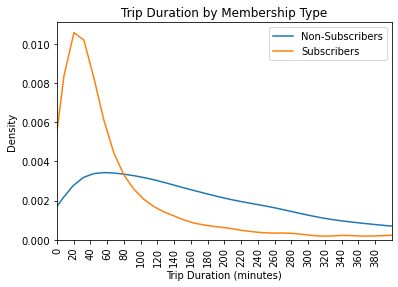

In [116]:
sns.kdeplot(data=non_subscribers['duration_min'])
sns.kdeplot(data=subscribers['duration_min'])
plt.title("Trip Duration by Membership Type")
plt.legend(["Non-Subscribers", "Subscribers"])
plt.xlim(0,400)
plt.xticks([i for i in range(0, 400, 20)], rotation='vertical')
plt.xlabel("Trip Duration (minutes)")
plt.ylabel("Density")

plt.show()

Since the average trip length for non-subscribers is significantly longer than that of subscribers, we may be able to increase our subscriber count by changing the maximum free duration length for subscribers from 45 minutes to 60 minutes. From the website (https://help.baywheels.com/hc/en-us/articles/360033788692-Annual-memberships):

"$149/ yr Annual Membership includes:

Unlimited 45-minute rides for a full year
24/7 access to thousands of bikes in San Francisco, East Bay, and San Jose
Trips longer than 45 minutes will incur an extra $3 per each additional 45-minutes."

The offer is similar for Monthly Memberships.

Since it appears that non-subscribers spend much more time on their bikes than subscribers (53 and a half minutes compared to 9 and a half minutes on average), we may be able to convince more one-off riders to become subscribers if we increase the maximum free duration for subscribers from 45 minutes to 60 minutes.

As we can see from the density plots, many more non-subscribers had trips longer than 45 minutes than subscribers. So, by modifying the annual membership and monthly membership to have free trips up to an hour rather than 45 minutes (since the peak density of non-subscriber trips appear to be between 40-60 minutes long) we may be able to convince more non-subscribers to become members.

### Recommendation 3: Increase advertisement of the Corporate Membership subscription.

In [25]:
%%bigquery --use_rest_api commuter_trips_by_subscriber_type
SELECT
subscriber_type,
COUNT(subscriber_type) AS number_of_trips
FROM
`bike_trip_data.commuter_trips`
GROUP BY
subscriber_type

In [26]:
commuter_trips_by_subscriber_type

,subscriber_type,number_of_trips
0,Customer,23581
1,Subscriber,424252


In [27]:
commuter_trips_by_subscriber_type['number_of_trips'].tolist()[0]/(
    commuter_trips_by_subscriber_type['number_of_trips'].tolist()[0] + 
    commuter_trips_by_subscriber_type['number_of_trips'].tolist()[1])

0.05265578909995467

Most commuters appear to be subscribers, implying they may be using the Corporate Membership subscription. However, we still have approximately 5% of apparent commuters who are not subscribers at all; because of this, I suggest we advertise our Corporate Membership more. Not only would we be able to potentially decrease the percent of non-subscribing commuters, but we may also increase the number of companies overall who subscribe to the Corporate Membership.

### Recommendation 4: Offer discounts on weekends, or weekend-specific memberships to increase weekend trips.

In [61]:
%%bigquery --use_rest_api trips_by_day
SELECT
dow_str,
COUNT(dow_str) AS day_counts
FROM
`bike_trip_data.day_time_trips`
GROUP BY
dow_str

/opt/conda/lib/python3.7/site-packages/google/cloud/bigquery/client.py:407: UserWarning: Cannot create BigQuery Storage client, the dependency google-cloud-bigquery-storage is not installed.
  "Cannot create BigQuery Storage client, the dependency "


In [62]:
trips_by_day = trips_by_day.reindex([5, 3, 6, 0, 2, 4, 1]).reset_index().drop('index', axis=1)
trips_by_day

,dow_str,day_counts
0,Monday,169937
1,Tuesday,184405
2,Wednesday,180767
3,Thursday,176908
4,Friday,159977
5,Saturday,60279
6,Sunday,51375


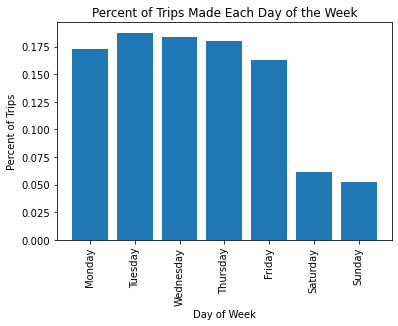

In [63]:
plt.bar(trips_by_day['dow_str'], trips_by_day['day_counts']/trips_by_day['day_counts'].sum())
plt.title("Percent of Trips Made Each Day of the Week")
plt.xlabel("Day of Week")
plt.ylabel("Percent of Trips")
plt.xticks(trips_by_day['dow_str'], rotation = 'vertical')
plt.show()

Since such a small proportion of trips are made on weekends, we may be able to increase the number of weekend trips by offering either a membership specific to weekend trips, or discounting trips made on weekends.

## Appendix: SQL View Queries

### number_of_trips_by_station view:
```
SELECT 
    start_station_name,
    end_station_name,
    COUNT(*) AS number_of_trips
FROM
    `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
    start_station_name <> end_station_name
GROUP BY
    start_station_name,
    end_station_name
ORDER BY
    number_of_trips ASC
```

### day_time_trips view:
```
SELECT trip_id, subscriber_type, start_date,
       EXTRACT(DAYOFWEEK FROM start_date) AS dow_int,
       CASE EXTRACT(DAYOFWEEK FROM start_date)
           WHEN 1 THEN "Sunday"
           WHEN 2 THEN "Monday"
           WHEN 3 THEN "Tuesday"
           WHEN 4 THEN "Wednesday"
           WHEN 5 THEN "Thursday"
           WHEN 6 THEN "Friday"
           WHEN 7 THEN "Saturday"
           END AS dow_str,
       CASE 
           WHEN EXTRACT(DAYOFWEEK FROM start_date) IN (1, 7) THEN "Weekend"
           ELSE "Weekday"
           END AS dow_weekday,
       EXTRACT(HOUR FROM start_date) AS start_hour,
       CASE 
           WHEN EXTRACT(HOUR FROM start_date) <= 5  OR EXTRACT(HOUR FROM start_date) >= 23 THEN "Nightime"
           WHEN EXTRACT(HOUR FROM start_date) >= 6 and EXTRACT(HOUR FROM start_date) <= 8 THEN "Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 9 and EXTRACT(HOUR FROM start_date) <= 10 THEN "Mid Morning"
           WHEN EXTRACT(HOUR FROM start_date) >= 11 and EXTRACT(HOUR FROM start_date) <= 13 THEN "Mid Day"
           WHEN EXTRACT(HOUR FROM start_date) >= 14 and EXTRACT(HOUR FROM start_date) <= 16 THEN "Early Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 17 and EXTRACT(HOUR FROM start_date) <= 19 THEN "Afternoon"
           WHEN EXTRACT(HOUR FROM start_date) >= 20 and EXTRACT(HOUR FROM start_date) <= 22 THEN "Evening"
           END AS start_hour_str
FROM `bigquery-public-data.san_francisco.bikeshare_trips`
ORDER BY start_date ASC
```

### trips_by_station view:
```
SELECT
  trip_id,
  start_station_name,
  end_station_name
FROM
  `bigquery-public-data.san_francisco.bikeshare_trips`
WHERE
  start_station_name <> end_station_name
ORDER BY
  1,
  2,
  3
```

### commuter_trips view:
```
SELECT
  trip_id,
  dow_weekday,
  start_hour_str,
  subscriber_type
FROM
  `sept-20.bike_trip_data.day_time_trips`
WHERE
  dow_weekday = 'Weekday' AND (start_hour_str = 'Morning' OR start_hour_str = 'Afternoon')
```

### commuter_trip_stations view:
```
SELECT
  `sept-20.bike_trip_data.trips_by_station`.start_station_name,
  `sept-20.bike_trip_data.trips_by_station`.end_station_name,
  `sept-20.bike_trip_data.trips_by_station`.start_station_id,
  `sept-20.bike_trip_data.trips_by_station`.end_station_id
FROM
  `sept-20.bike_trip_data.trips_by_station`
INNER JOIN
  `sept-20.bike_trip_data.commuter_trips`
ON
  `sept-20.bike_trip_data.trips_by_station`.trip_id=`sept-20.bike_trip_data.commuter_trips`.trip_id
```

### commuter_trips_with_empty_bikes view
```
SELECT
  `sept-20.bike_trip_data.commuter_trip_stations`.start_station_name,
  `sept-20.bike_trip_data.commuter_trip_stations`.end_station_name,
  `sept-20.bike_trip_data.commuter_trip_stations`.start_station_id,
  `sept-20.bike_trip_data.commuter_trip_stations`.end_station_id
FROM
  `sept-20.bike_trip_data.commuter_trip_stations`
INNER JOIN
  `sept-20.bike_trip_data.empty_station_names`
ON
  `sept-20.bike_trip_data.empty_station_names`.station_id=`sept-20.bike_trip_data.commuter_trip_stations`.start_station_id
```

### commuter_stations_with_empty_bikes view
```
SELECT
  start_station_id,
  start_station_name,
  end_station_name,
  COUNT(*) AS number_of_trips
FROM
  `sept-20.bike_trip_data.commuter_trips_with_empty_bikes`
WHERE
  start_station_name <> end_station_name
GROUP BY
  start_station_name,
  end_station_name,
  start_station_id
HAVING
  number_of_trips > 100
ORDER BY
  number_of_trips DESC
```

### empty_stations_counts view
```
SELECT
  station_id,
  COUNT(station_id) AS counts
FROM
  `bigquery-public-data.san_francisco.bikeshare_status`
WHERE
  bikes_available = 0
GROUP BY
  station_id
```